**Aula:** *APRENDIZADO DINÂMICO*<br>
**Professor:** *Cibele Russo*<br>
**Aluno:** *Guilherme Lourenço*<br>
**Projeto:** *Atividade Final - Aprendizado Dinâmico*


Para esta avaliação, você deve entregar três arquivos:
- um arquivo de dados em .csv com a base resultante das análises
- um relatório em .ipynb com suas análises comentadas
- um arquivo .pdf gerado a partir do .ipynb

Os dados de casos confirmados e mortes diárias por COVID-19 nos Estados Unidos estão
disponíveis no arquivo covid19USA.csv.

1. Você deve fazer a leitura dos dados, estabelecer um índice por datas, verificar se os
dados estão corretos e realizar algum procedimento necessário caso haja dados
faltantes.

## Importação de Bibliotecas

Iniciamos o processo com a importação das Bibliotecas principais para manipulação da base de dados.

- Pandas
- Matplotlib
- Numpy

Com relação a biblioteca _Matplotlib_, após a importação da biblioteca definimos alguns padrões para a visualização dos gráficos:
- Tamanho do Gráfico: 25 x 6
- Tamanho da Fonte: 14

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

plt.rcParams['figure.figsize'] = (25.0, 6.0) # Define o tamanho padrão das "plotagens"
plt.rc('font', size=14) # Altera o tamanho da fonte

## Importação da Base de Dados

Após a importação das bibliotecas, realizamos a importação da base de Dados **covid19USA.csv** que será utilizada durante o processo.

### Tratamentos da base

A importação da base é realizada através da biblioteca _pandas_, indicando a coluna a ser utilizada como _Index_ do DataFrame Pandas.

Após a importação, foi realizado um ajuste no _Index_ da base para que o range das datas estejam completos, além da definição do período padrão do _Index_ como sendo um período	diário.

Caso após o ajuste do _Index_ haja algum valor _nulo_, o número 0 (zero) é utilizado para substituir esse _nulo_.

### Ajuste adicional

Seguindo orientações publicadas no Fórum da Matéria, realizamos o ajuste manual da base de dados alteradando os valores de _deaths_ (mortes) para as seguintes datas:
- 19/03/2020: de **43** para **42**
- 20/03/2020: de **0** para **1**

Essas alterações foram realizadas antes da importação da base para que não tenha grande impacto na codificação do projeto.

In [27]:
# Importação da base de Dados
covid = pd.read_csv('covid19USA.csv', index_col='date', parse_dates=True)

# Ajuste do Index para conter o período completo
idx = pd.date_range(start=covid.index.min(), end=covid.index.max(), freq='D')
covid = covid.reindex(idx)

# Remoção da variável "idx" para redução do consumo de memória
del idx

# Ajuste de possíveis valores nulos/missing
covid.fillna(0, inplace=True)

covid.head()

,confirmed,deaths
2020-01-01,0,0
2020-01-02,0,0
2020-01-03,0,0
2020-01-04,0,0
2020-01-05,0,0


## Dados da Base

A base importada foi as seguintes caracteríticas:

- Atributos:
> - date: data de registro das informações (utilizado no Index) | Período entre 01/01/2020 e 03/09/2020
> - confirmed: casos confirmados de COVID-19 nos Estados Unidos<br>
> - deaths: mortes confirmadas por COVID-19 nos Estados Unidos

- Registros
> - **247** Registros <br>
> - Não foram encontrados nulos (mesmo antes das alterações realizadas na importação da base) <br>
> - Atributos de tipo Inteiro <br>

In [4]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 247 entries, 2020-01-01 to 2020-09-03
Freq: D
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   confirmed  247 non-null    int64
 1   deaths     247 non-null    int64
dtypes: int64(2)
memory usage: 5.8 KB


## Análise descritiva

Abaixo podemos ver alguns dados estatístico sobre a distribuição dos dados, bem como sua média e desvio padrão.<br><br>
Após as descritivas, temos o gráfico contendo toda a série temporal da base de dados COVID-19.

In [4]:
covid.describe()

,confirmed,deaths
count,247.000000,247.000000
mean,24754.680162,752.000000
std,21935.393529,768.724717
min,0.000000,0.000000
25%,19.500000,1.000000
50%,23705.000000,661.000000
75%,41252.500000,1180.500000
max,78427.000000,4928.000000


### Boxplot: **Casos confirmados**

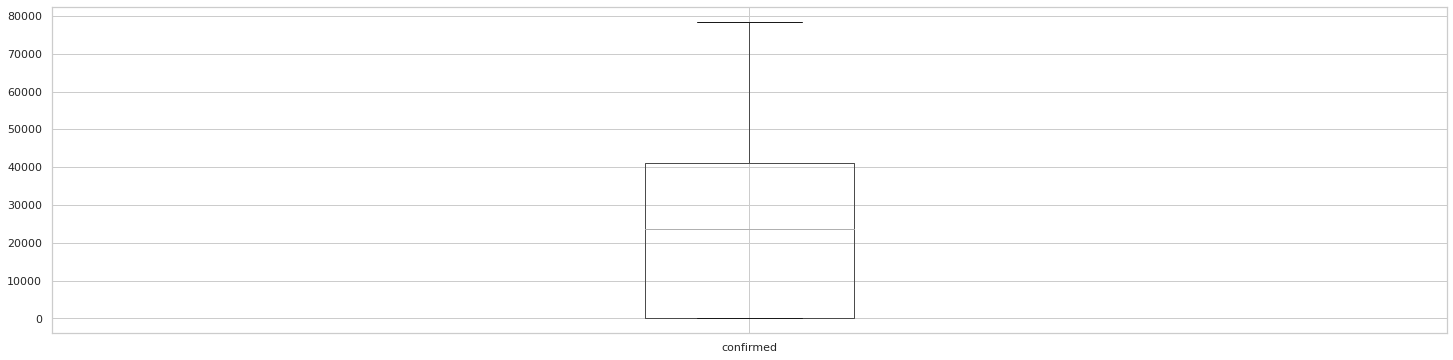

In [5]:
covid[['confirmed']].boxplot();

### Boxplot: **Mortes confirmadas**

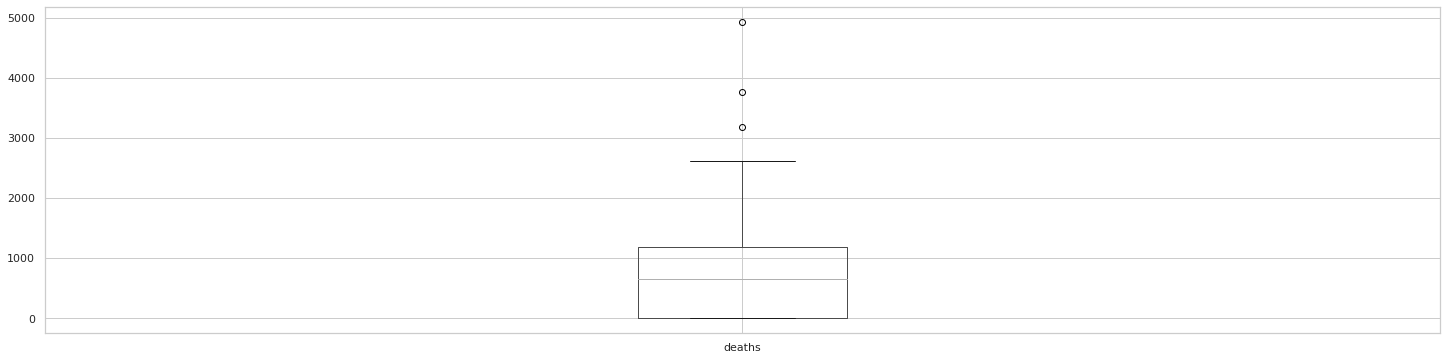

In [6]:
covid[['deaths']].boxplot();

### **Casos confirmados** e **Mortes confirmadas**

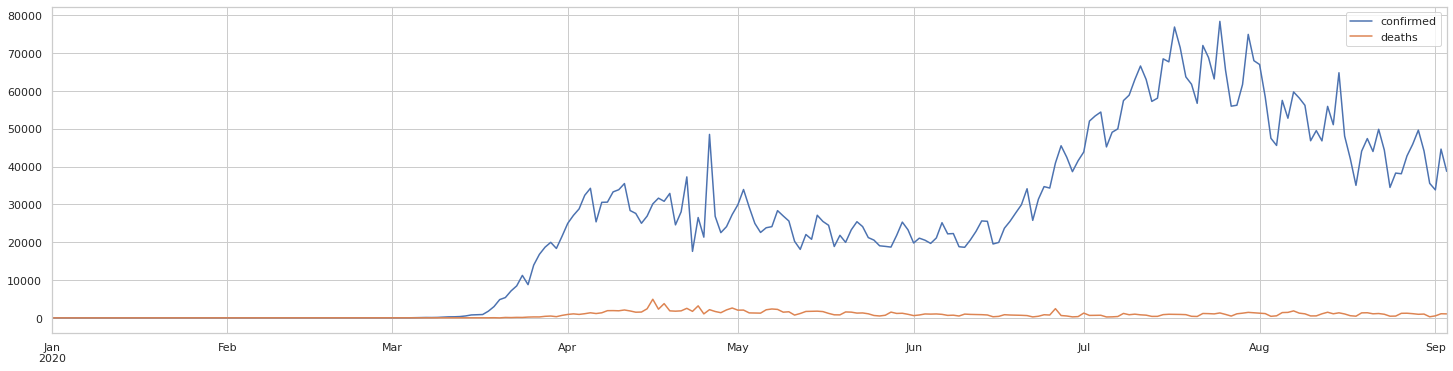

In [7]:
covid.plot();

2. Proponha uma decomposição dos dados de mortes em tendência e sazonalidade.
Obtenha os gráficos de autocorrelação e autocorrelação parcial. Comente
brevemente os resultados.

## Decomposição de Tendência e Sazonalidade

Ao se analisar uma ou mais séries temporais a representação gráfica dos dados sequencialmente ao longo do tempo é fundamental e pode revelar padrões de comportamento importantes.(Ehlers, 2009)

Utilizando a função *seasonal_decompose* da biblioteca *statsmodels.tsa.seasonal*, é possível analisar graficamente a decomposição da Tendência e da Sazonalidade presente na base de dados do COVID-19.


In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

### Modelo - Aditivo

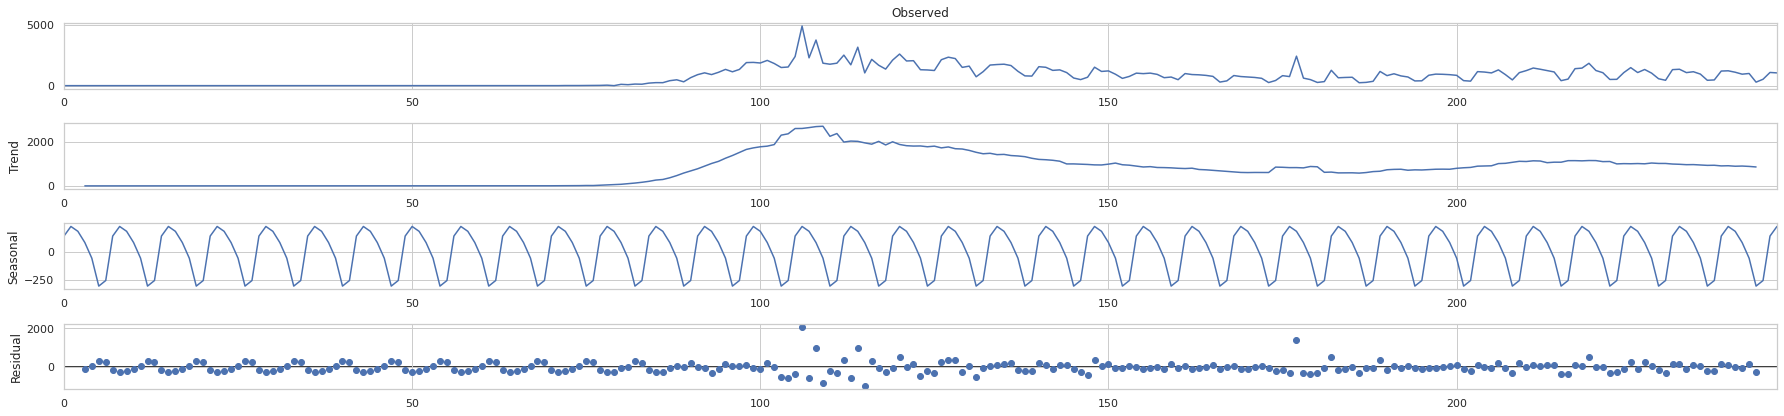

In [23]:
aditivo = seasonal_decompose(np.array(list(covid.deaths)), model='additive', period=7)
aditivo.plot()

plt.show()

### Modelo - Multiplicativo

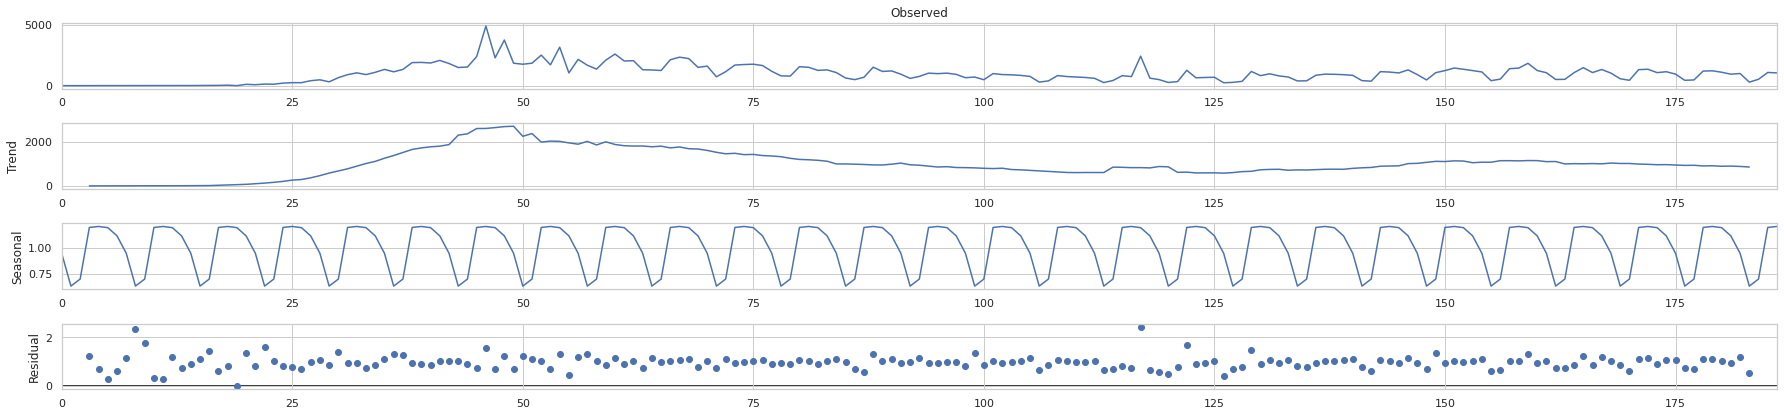

In [53]:
multiplicativo = seasonal_decompose(np.array(list(covid.deaths[covid.deaths > 0])), model='multiplicative', period=7)
multiplicativo.plot()
plt.show()

## Análise dos Resíduos

Após a decomposição da base utilizando modelos _aditivos_ e _multiplicativos_, decidimos seguir com a aplicação de modelos _multiplicativos_ com base na análise dos Resíduos apresentados na decomposição.

Como pode ser observado abaixo, os Resíduos apresentados pelo modelo _multiplicativo_ demonstram uma aleatoriedade, diferente dos Resíduos do modelo _aditivo_ que em seu início apresenta um determinado padrão.

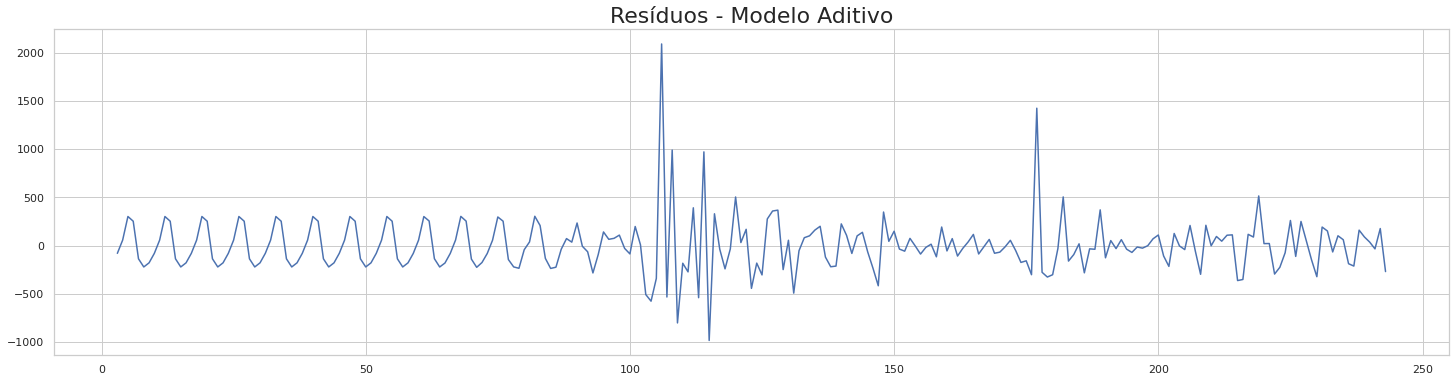

In [44]:
# Exibição gráfica dos resíduos
plt.plot(aditivo.resid)
plt.title("Resíduos - Modelo Aditivo", fontdict = {'fontsize':22})
plt.show();

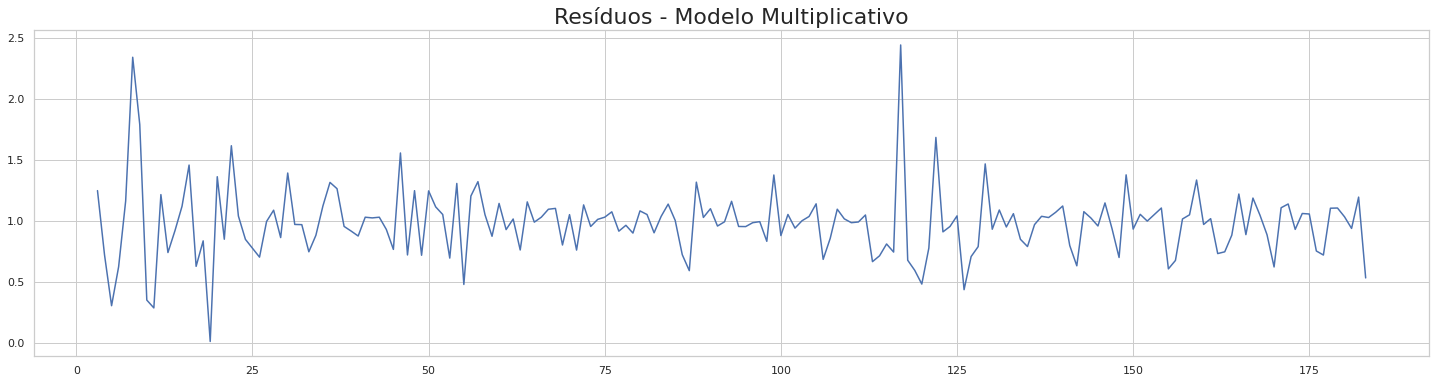

In [43]:
# Exibição gráfica dos resíduos
plt.plot(multiplicativo.resid)
plt.title("Resíduos - Modelo Multiplicativo", fontdict = {'fontsize':22})
plt.show();

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

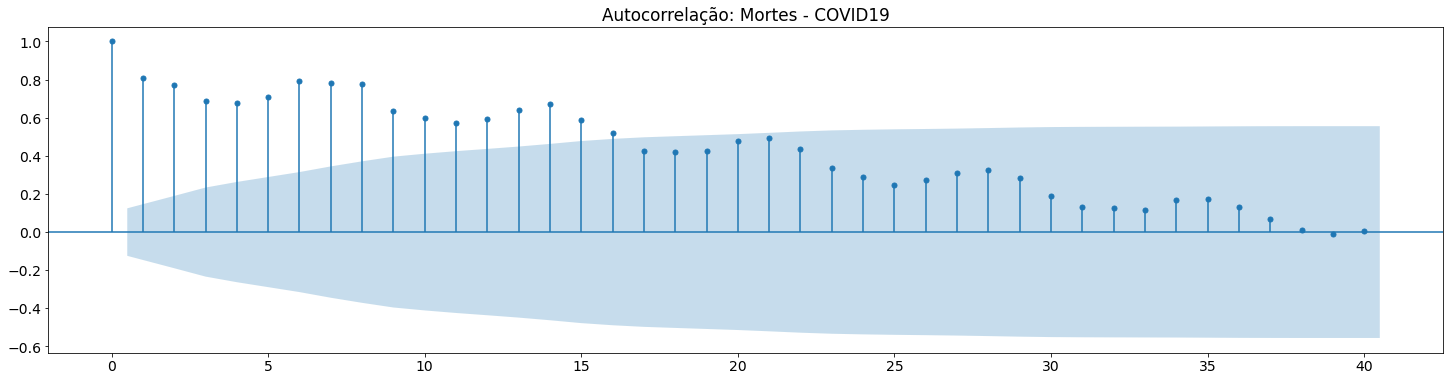

In [9]:
title = 'Autocorrelação: Mortes - COVID19'
lags = 40
plot_acf(covid.deaths, title=title,lags=lags);

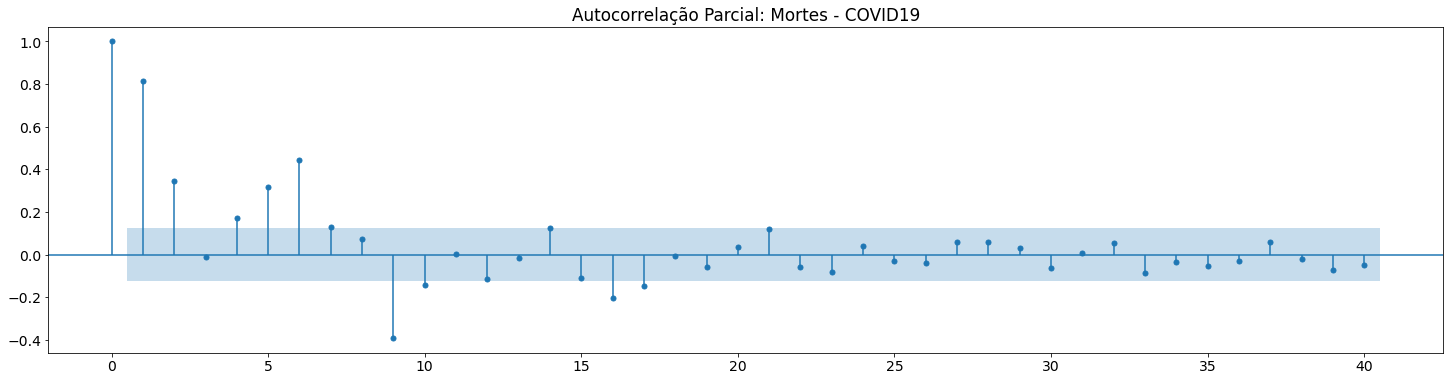

In [10]:
title = 'Autocorrelação Parcial: Mortes - COVID19'
lags = 40
plot_pacf(covid.deaths, title=title,lags=lags);

3. Divida a base em treino e teste, com 21 observações na base de teste. Você deverá
apresentar em distintas colunas na mesma base de dados que será entregue:
- Os dados originais de casos confirmados e mortes.
- As previsões de Holt e Holt Winters para a variável mortes.
- As previsões obtidas pelo melhor modelo SARIMA, com ordens selecionadas
segundo critério preestabelecido para a variável mortes. Identifique as
componentes desse melhor modelo (por exemplo, “o modelo tem uma
componente autorregressiva não sazonal de ordem .., uma componente de
médias móveis não-sazonal de ordem.., etc).
- As previsões obtidas por um modelo de redes dinâmicas para a variável
mortes.

In [11]:
treino = covid.iloc[:226]
teste = covid.iloc[226:]

In [12]:
# Método de Holt 

from statsmodels.tsa.api import ExponentialSmoothing

modelo =  ExponentialSmoothing(treino.deaths, trend='add').fit();

treino['Holt'] = modelo.fittedvalues.shift(-1);
treino.head()

,confirmed,deaths,Holt
2020-01-01,0,0,8.393346
2020-01-02,0,0,10.751757
2020-01-03,0,0,12.378175
2020-01-04,0,0,13.499792
2020-01-05,0,0,14.273287


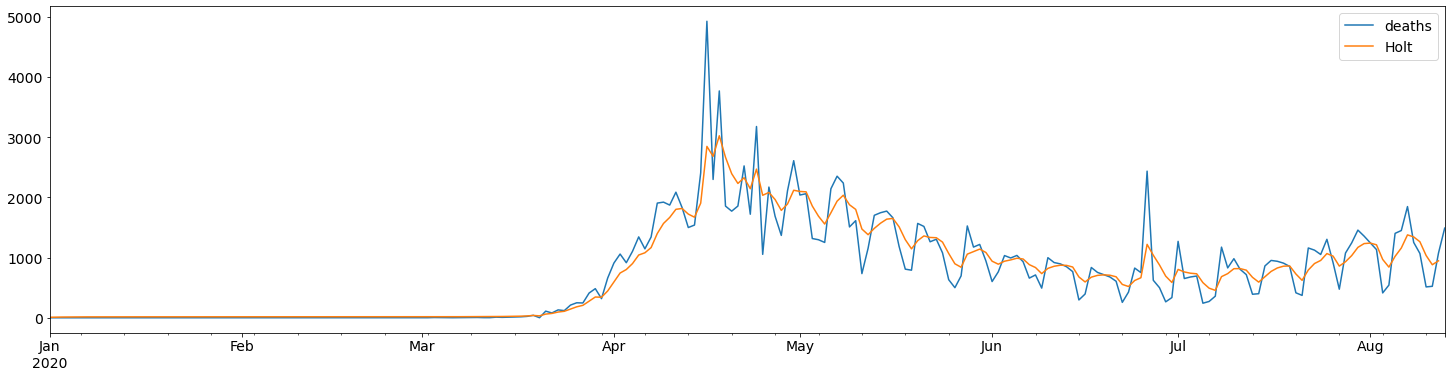

In [13]:
treino[['deaths','Holt']].plot(figsize=(25,6)).autoscale(axis='x',tight=True);

In [14]:
# Ajuste do modelo pelo Método de Holt-Winters com sazonalidade aditiva

modelo =  ExponentialSmoothing(treino.deaths,trend='add',seasonal='add',seasonal_periods=7).fit()

treino['Holt-Winters-adit-7'] = modelo.fittedvalues

treino.head()

,confirmed,deaths,Holt,Holt-Winters-adit-7
2020-01-01,0,0,8.393346,42.785459
2020-01-02,0,0,10.751757,34.641374
2020-01-03,0,0,12.378175,-38.951047
2020-01-04,0,0,13.499792,-47.284946
2020-01-05,0,0,14.273287,-61.665457


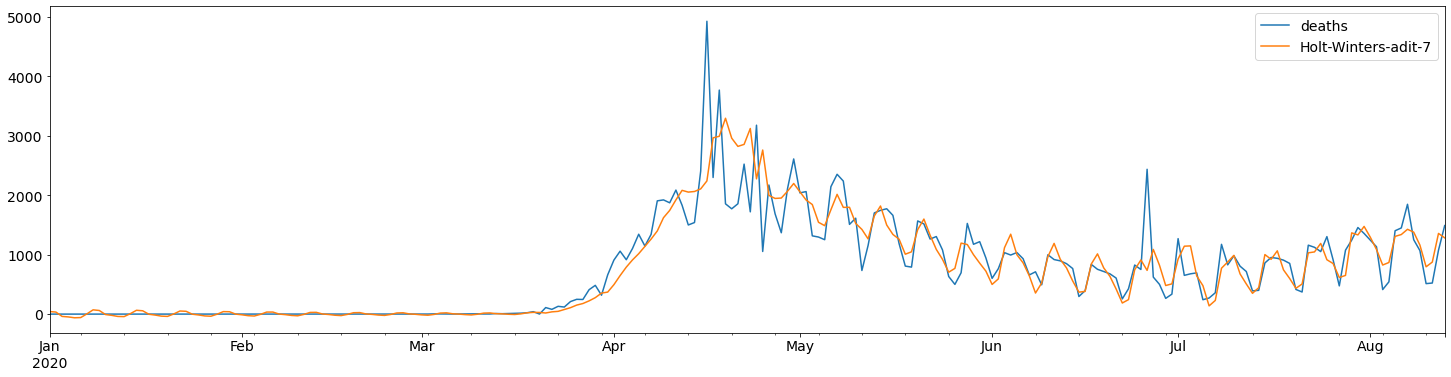

In [15]:
treino[['deaths','Holt-Winters-adit-7']].plot(figsize=(25,6)).autoscale(axis='x',tight=True);

In [16]:
# Base de Treinamento para métodos multiplicativos
treino_mult = covid.iloc[:226]
teste_mult = covid.iloc[226:]

treino_mult = treino_mult[treino_mult.deaths > 0]
teste_mult = teste_mult[teste_mult.deaths > 0]

In [17]:
# Método de Holt 

from statsmodels.tsa.api import ExponentialSmoothing

modelo =  ExponentialSmoothing(treino_mult.deaths, trend='mul').fit();

treino_mult['Holt'] = modelo.fittedvalues.shift(-1);
treino_mult.head()# Método de Holt 


,confirmed,deaths,Holt
2020-03-01,3,1,1.701813
2020-03-02,20,1,1.470976
2020-03-03,14,4,2.257443
2020-03-04,22,3,2.477468
2020-03-05,34,2,2.312548


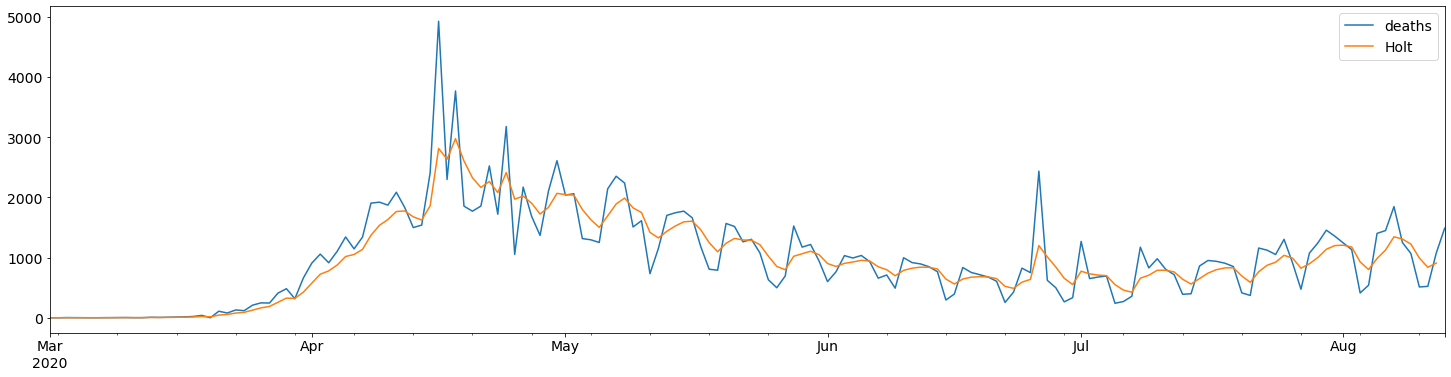

In [18]:
treino_mult[['deaths','Holt']].plot(figsize=(25,6)).autoscale(axis='x',tight=True);

In [19]:
# Ajuste do modelo pelo Método de Holt-Winters com sazonalidade multiplicativa

modelo =  ExponentialSmoothing(treino_mult.deaths,trend='add',seasonal='mul',seasonal_periods=7).fit()

treino_mult['Holt-Winters-mult-7'] = modelo.fittedvalues

treino_mult.head()

,confirmed,deaths,Holt,Holt-Winters-mult-7
2020-03-01,3,1,1.701813,1.000435
2020-03-02,20,1,1.470976,1.000750
2020-03-03,14,4,2.257443,4.003885
2020-03-04,22,3,2.477468,3.003363
2020-03-05,34,2,2.312548,2.002432


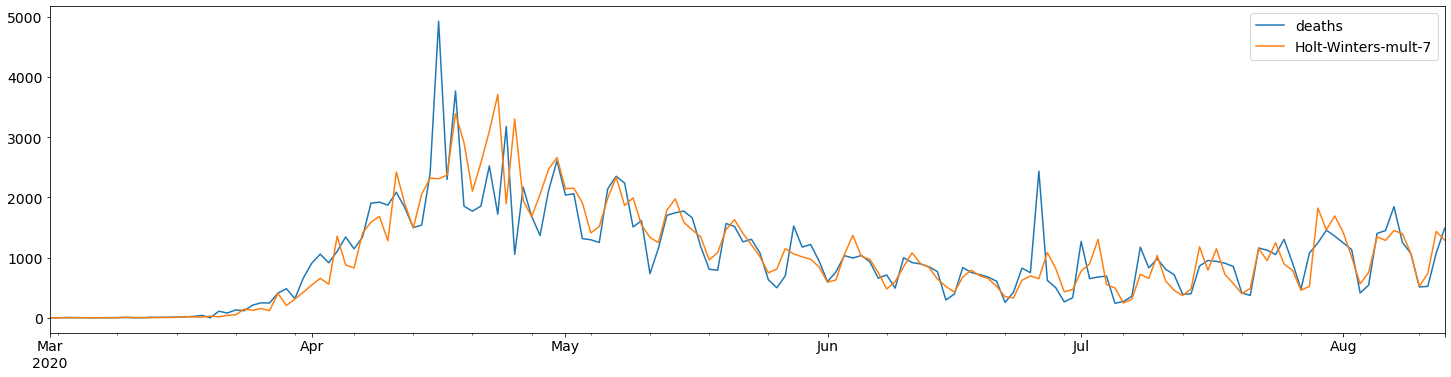

In [20]:
treino_mult[['deaths','Holt-Winters-mult-7']].plot(figsize=(25,6)).autoscale(axis='x',tight=True);

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima                              

# Ignorar warnings não prejudiciais
import warnings
warnings.filterwarnings("ignore")

In [54]:

auto_arima(covid.deaths,seasonal=True,m=7).summary()

stepwise_fit = auto_arima(covid.deaths, start_p=0, start_q=0,
                          max_p=6, max_q=3, m=7,
                          seasonal=True,
                          trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)           

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=3733.997, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=3729.997, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=3654.779, Time=0.41 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=3652.583, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=3728.020, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=3667.602, Time=0.13 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=3596.111, Time=1.17 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=3638.859, Time=0.44 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=3592.677, Time=5.92 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=3603.517, Time=2.33 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=3600.128, Time=5.61 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=3594.066, Time=4.90 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=3688.292, Time=3.25 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=3587.405, Time=4.13 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  247
Model:             SARIMAX(3, 1, 3)x(2, 0, [1], 7)   Log Likelihood               -1775.120
Date:                             Thu, 17 Sep 2020   AIC                           3570.240
Time:                                     19:23:20   BIC                           3605.293
Sample:                                          0   HQIC                          3584.354
                                             - 247                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7992      0.076     10.561      0.000       0.651       0.947
ar.L2         -0.4248      0.095     -4.457      0.000      -0.612      -0.238
ar.L3         -0.4127      0.054     -7.626      0.000      -0.519      -0.307
ma.L1         -1.5506      0.080    -19.346      0.000      -1.708      -1.393
ma.L2          1.2929      0.115     11.283      0.000       1.068       1.517
ma.L3         -0.3441      0.071     -4.814      0.000      -0.484      -0.204
ar.S.L7        0.7893      0.225      3.505      0.000       0.348       1.231
ar.S.L14       0.1104      0.104      1.061      0.289      -0.094       0.314
ma.S.L7       -0.7776      0.200     -3.887      0.000      -1.170      -0.385
sigma2      1.133e+05   4101.893     27.624      0.000    1.05e+05    1.21e+05
===================================================================================
Ljung-Box (Q):                       43.83   Jarque-Bera (JB):              8362.28
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):             526.10   Skew:                             2.86
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
from sklearn.preprocessing import MinMaxScaler

In [24]:
scaler = MinMaxScaler()

In [25]:
treino = treino.drop(['confirmed', 'Holt', 'Holt-Winters-adit-7'], axis=1)
teste = teste.drop('confirmed', axis=1)

In [26]:
treino

,deaths
2020-01-01,0
2020-01-02,0
2020-01-03,0
2020-01-04,0
2020-01-05,0
...,...
2020-08-09,1069
2020-08-10,513
2020-08-11,523
2020-08-12,1076


In [27]:
scaler.fit(treino)

MinMaxScaler()

In [28]:
scaled_train = scaler.transform(treino)
scaled_test = scaler.transform(teste)

In [29]:
print(scaled_train.min(),scaled_train.max())

0.0 1.0


In [30]:
print(scaled_test.min(),scaled_test.max())

0.0588474025974026 0.27516233766233766


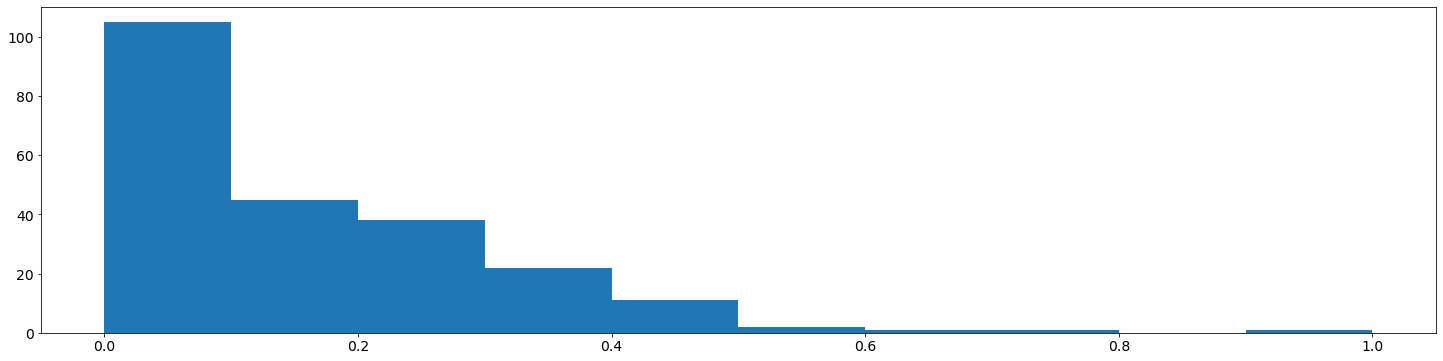

In [31]:
plt.hist(scaled_train);

In [32]:
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [33]:
# defina o gerador
n_input = 2
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [34]:
n_input = 7
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=2)

In [35]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [36]:
# Defina o modelo
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.fit_generator(generator,epochs=100)


Epoch 1/100
110/110 [==============================] - 1s 12ms/step - loss: 0.0139
Epoch 2/100
110/110 [==============================] - 1s 8ms/step - loss: 0.0087
Epoch 3/100
110/110 [==============================] - 1s 8ms/step - loss: 0.0080
Epoch 4/100
110/110 [==============================] - 1s 8ms/step - loss: 0.0081
Epoch 5/100
110/110 [==============================] - 1s 9ms/step - loss: 0.0078
Epoch 6/100
110/110 [==============================] - 1s 8ms/step - loss: 0.0077
Epoch 7/100
110/110 [==============================] - 1s 8ms/step - loss: 0.0079
Epoch 8/100
110/110 [==============================] - 1s 9ms/step - loss: 0.0075
Epoch 9/100
110/110 [==============================] - 1s 8ms/step - loss: 0.0073
Epoch 10/100
110/110 [==============================] - 1s 8ms/step - loss: 0.0075
Epoch 11/100
110/110 [==============================] - 1s 8ms/step - loss: 0.0075
Epoch 12/100
110/110 [==============================] - 1s 8ms/step - loss: 0.0070
Epoch 13/10

In [39]:
model.history.history.keys()

dict_keys(['loss'])

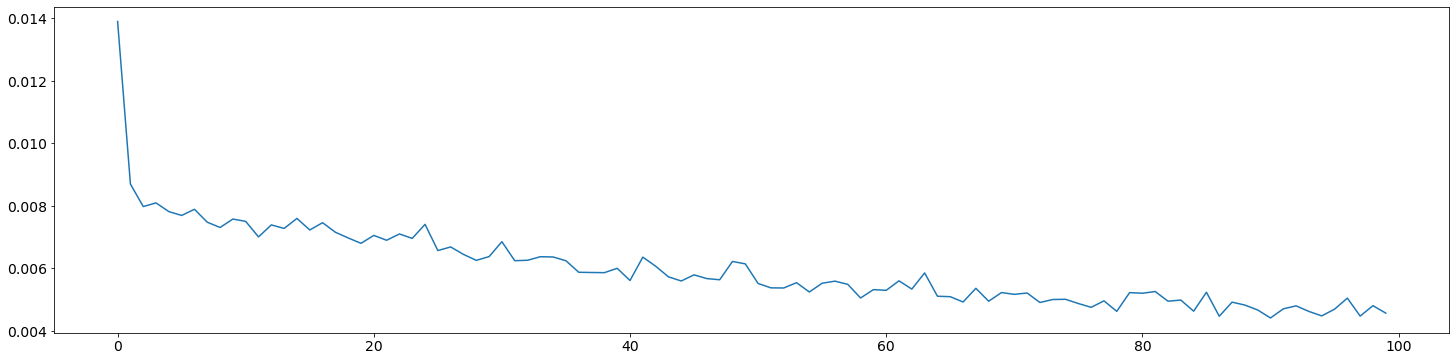

In [40]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch);

In [41]:
first_eval_batch = scaled_train[-7:]

In [42]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [43]:
model.predict(first_eval_batch)

array([[0.28137755]], dtype=float32)

In [44]:
scaled_test[0]

array([0.21976461])

In [45]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [46]:
current_batch.shape

(1, 7, 1)

In [47]:
np.append(current_batch[:,1:,:],[[[99]]],axis=1)

array([[[ 0.25405844],
        [ 0.2169237 ],
        [ 0.10409903],
        [ 0.10612825],
        [ 0.21834416],
        [ 0.3023539 ],
        [99.        ]]])

In [48]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(teste)):
    
    # obter a previsão de tempo 1 antecipadamente ([0] é para pegar apenas o número em vez de [array])
    current_pred = model.predict(current_batch)[0]
    
    # predição
    test_predictions.append(current_pred) 
    
    # atualize a rodada para agora incluir a previsão e descartar o primeiro valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [49]:
true_predictions = scaler.inverse_transform(test_predictions)

In [50]:
teste['Predictions'] = true_predictions

In [51]:
teste

,deaths,Predictions
2020-08-14,1083,1386.628586
2020-08-15,1336,1178.310987
2020-08-16,1035,884.028992
2020-08-17,571,555.932053
2020-08-18,445,425.631060
2020-08-19,1324,775.378080
2020-08-20,1356,1073.073385
2020-08-21,1078,1165.185293
2020-08-22,1151,1071.391551
2020-08-23,956,890.540583


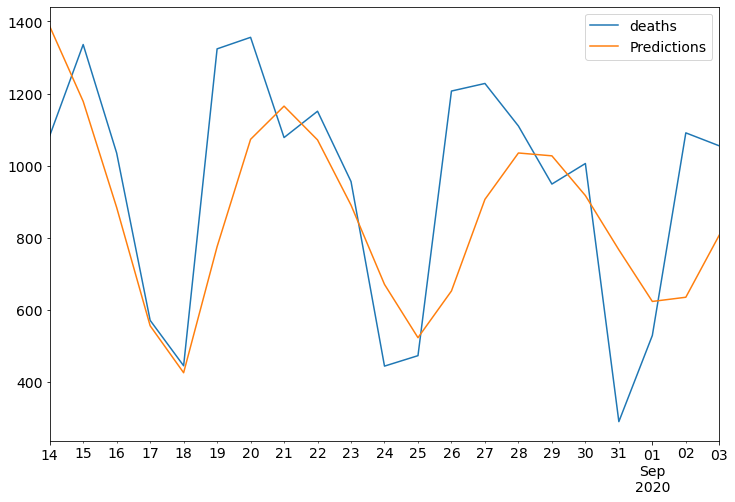

In [52]:
teste.plot(figsize=(12,8));

In [53]:
model.save('my_rnn_model.h5')